## E2E example on Allergic Rhinitis Gesture Dataset
Each instance in this dataset corresponds to a gesture collected from a  
wearable device (smartwatch) collecting data from 8 different axes.

#### Import Configuration Module

In [1]:
import yaml

Load configuration file

In [2]:
with open("../config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

#### Load Tabular-like data with more than one dimension/column

In [3]:
from crossai.loader import csv_loader

data_dir_path = config["PATH"]["RAW"]["GESTURE_SET"] + "/train"
df = csv_loader(path=data_dir_path)
df.head()

Loaded classes: ['null', 'null_plus', '02c', '03a', '03c', '01a', '02b', 'rest', '01b', '01d', '01c', '03b', '02a']


,instance,label,feature,data
0,1,null,acc_x_axis_g,"[-0.04, -0.103, -0.16, -0.212, -0.251, -0.28, ..."
1,1,null,acc_y_axis_g,"[-0.999, -0.976, -0.975, -0.99, -0.989, -0.98,..."
2,1,null,acc_z_axis_g,"[0.017, 0.055, 0.094, 0.128, 0.162, 0.19, 0.20..."
3,1,null,gyr_x_axis_deg/s,"[-25.864, -14.457, -8.418, -8.296, -11.956, -1..."
4,1,null,gyr_y_axis_deg/s,"[130.54, 139.69, 142.74, 140.483, 133.773, 123..."


#### Create CrossAI Tabular Data Object to be Used for the Pipeline

In [4]:
from crossai.pipelines.tabular import Tabular

cai_tabular = Tabular(df)

In [5]:
cai_tabular.data.sample(1).values[0].shape

(1662,)

In [6]:
print(cai_tabular.data.shape)

(2256,)


##### Contruct Processing Pipeline

In [7]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# crossai
from crossai.pipelines import TimeMeasurementWrapper
from crossai.pipelines.tabular import MagnitudeExtractor, AxisToModelShape, \
    MultiAxisSlidingWindow
from crossai.pipelines.motion import PureAccExtractor
from crossai.pipelines.preparation import Scaler

# this pipeline component extracts the magnitude from each axis/feature of a 
# motion signal while measuring the time spent for this pipeline step
ME = TimeMeasurementWrapper(
    MagnitudeExtractor(
        [[["acc_x_axis_g","acc_y_axis_g","acc_z_axis_g"],"acc_mag"],
        [["gyr_x_axis_deg/s","gyr_y_axis_deg/s","gyr_z_axis_deg/s"],"gyr_mag"]]
    )
)

# Extracts the pure acceleration from a motion signal for each axis
PAX = TimeMeasurementWrapper(
    PureAccExtractor(
        Fs=100,
        acc_x="acc_x_axis_g",
        acc_y="acc_y_axis_g",
        acc_z="acc_z_axis_g"
    )
)

# performs sliding window of a motion signal for each axis
MSW = TimeMeasurementWrapper(MultiAxisSlidingWindow(window_size=50, overlap=25))

# scales each motion signal at (0, 1)
SS = TimeMeasurementWrapper(Scaler(StandardScaler()))

# converts the axes of a motion signal to (instance, window_size, axes) 
AXMS = TimeMeasurementWrapper(AxisToModelShape())

In [8]:
# perform pipeline
pipe = Pipeline([
    ("magex", ME),
    ("MSW", MSW),
    ("SS", SS),
    ("AXMS", AXMS),
])
pipe.fit_transform(cai_tabular)

Transformer MagnitudeExtractor took 0.00 seconds to fit.
Transformer MagnitudeExtractor took 0.48 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.00 seconds to fit.
Transformer MultiAxisSlidingWindow took 26.68 seconds to transform.
Transformer Scaler took 0.00 seconds to fit.
Transformer Scaler took 0.16 seconds to transform.
Transformer AxisToModelShape took 0.00 seconds to fit.
Transformer AxisToModelShape took 3.44 seconds to transform.


#### Data Shape after the Pipeline

In [9]:
print(cai_tabular.data.shape)

(42604, 50, 8)


#### Data Preparation for training

In [10]:
# split data on train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cai_tabular.data,
                                                    cai_tabular.labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
X_train.shape, X_test.shape

((34083, 50, 8), (8521, 50, 8))

In [12]:
y_train.shape, y_test.shape

((34083,), (8521,))

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

#### Create AI Model through CrossAI module

In [14]:
# disable TF debug warnings and numpy import 
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np

In [15]:
from crossai.ai.nn1d import CNN1D

cnn1d = CNN1D(
    input_shape=X_train.shape[1:],
    include_top=True,
    num_classes=np.unique(y_train).shape[0],
    classifier_activation="softmax",
    drp=.5,
    spatial=False,
    mc_inference=None
)

cnn1d.summary()

Model: "CNN1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            1600      
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 64)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 128)           49280     
                                                             

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# callbacks for the training process
early_stopping = EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.00001)

In [17]:
# compile model
cnn1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [18]:
history = cnn1d.fit(X_train, y_train,
                    epochs=100,
                    validation_split=.2,
                    verbose=0,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr]
                    )

In [19]:
cnn1d.evaluate(X_test, y_test, return_dict=True)

267/267 [==============================] - 1s 3ms/step - loss: 0.2410 - accuracy: 0.9105


{'loss': 0.24097810685634613, 'accuracy': 0.9104565382003784}

##### Plot Learning Curves

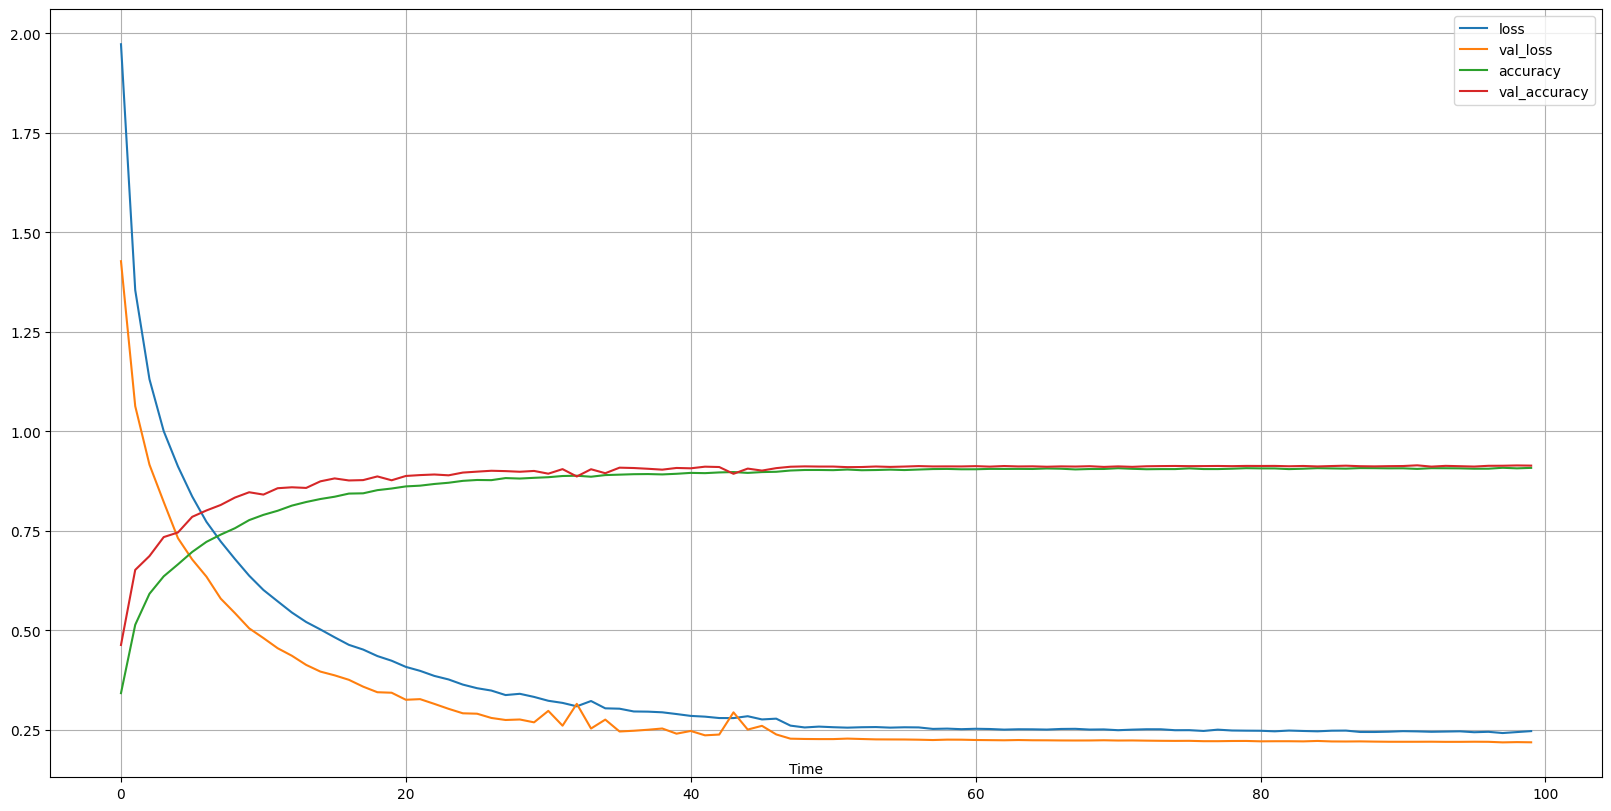

In [20]:
from crossai.visualization import plot_ts

plot_ts([
    history.history["loss"], history.history["val_loss"],
    history.history["accuracy"], history.history["val_accuracy"]
    ],
    labels=["loss", "val_loss", "accuracy", "val_accuracy"])

267/267 [==============================] - 1s 2ms/step


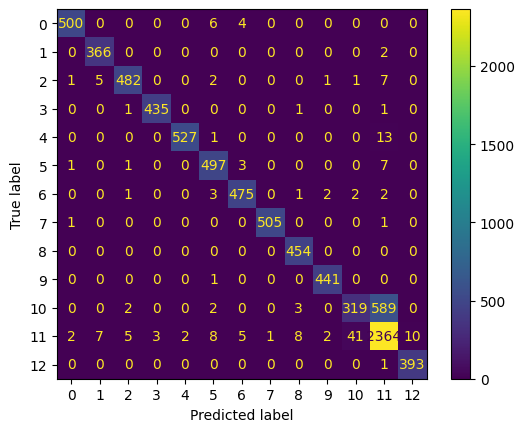

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(cnn1d.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot()

## Train a statistical model

##### Prepare data

In [22]:
# flatten -> (instances, timesteps * axes)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

X_test_flatten.shape, X_test_flatten.shape

((8521, 400), (8521, 400))

In [23]:
# train a random forest classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train_flatten, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

#### Make predictions

In [24]:
y_pred_probs = model.predict_proba(X_test_flatten)
predictions = model.predict(X_test_flatten)

##### Plot Confusion Matrix

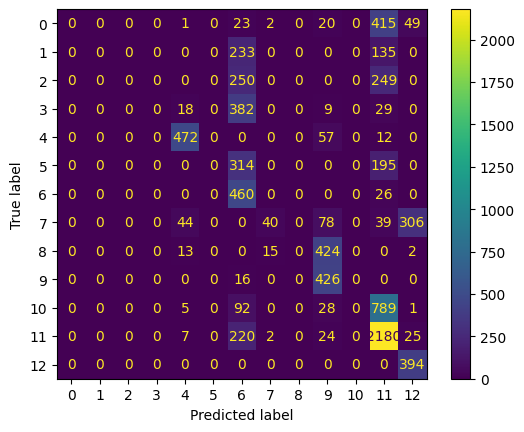

In [25]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Evaluation

In [26]:
print(le.classes_)

['01a' '01b' '01c' '01d' '02a' '02b' '02c' '03a' '03b' '03c' 'null'
 'null_plus' 'rest']


In [27]:
import crossai.performance.loader as cpl

# path to pilot gesture instance
eval_instance_path = config["PATH"]["EVALUATION"]["INSTANCE"]
# load evaluation object by providing the path to the folder containing the data,
# the baseline label and the label mapping
cai_eval_tab = cpl.csv_loader(eval_instance_path, list(le.classes_))

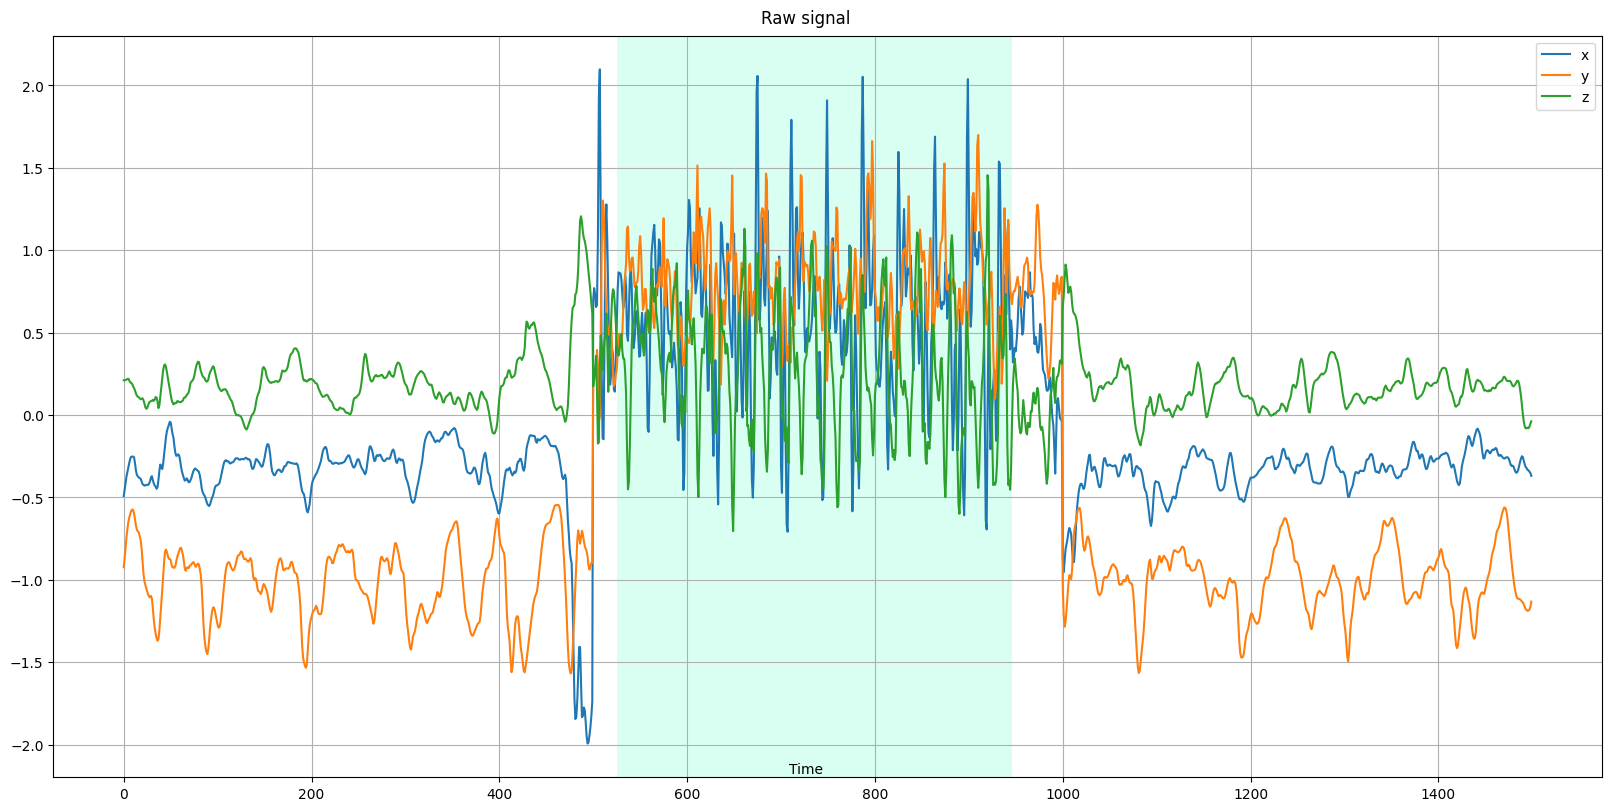

In [28]:
from crossai.visualization import plot_ts
plot_ts(
    data=cai_eval_tab.data[0:3], 
    title="Raw signal",
    labels=["x","y","z"], 
    segments=[[525,946,"aquamarine"]]
)

Perform similar processing as with train data

In [29]:
# transform pilot instance 
pipe.transform(cai_eval_tab)

Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.01 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.00 seconds to transform.


In [30]:
print(cai_eval_tab.data.shape)

(58, 50, 8)


#### Perform Pilot Evaluation

In [31]:
from crossai.performance.pilot_evaluation import evaluate

results = evaluate(model=cnn1d,
                   data=cai_eval_tab.data, 
                   labels=cai_eval_tab.labels,
                   repeats=2)

In [40]:
print("mean_predictions: ", results["mean_pred"])
print("STD:", results["std"])
print("Variance:", results["variance"])
print("Entropy: ", results["entropy"])
print("Predicted Classes: ", results["class"])

Count Insertions, deletions, substitutions and corrects

In [41]:
print("Y_eval: ", cai_eval_tab.labels)
print("Y_pred: ", results["class"])

print("Insertions: ", results["insertions"])
print("Deletions: ", results["deletions"])
print("Substitutions: ", results["substitutions"])
print("Corrects: ", results["correct"])

#### Plot section

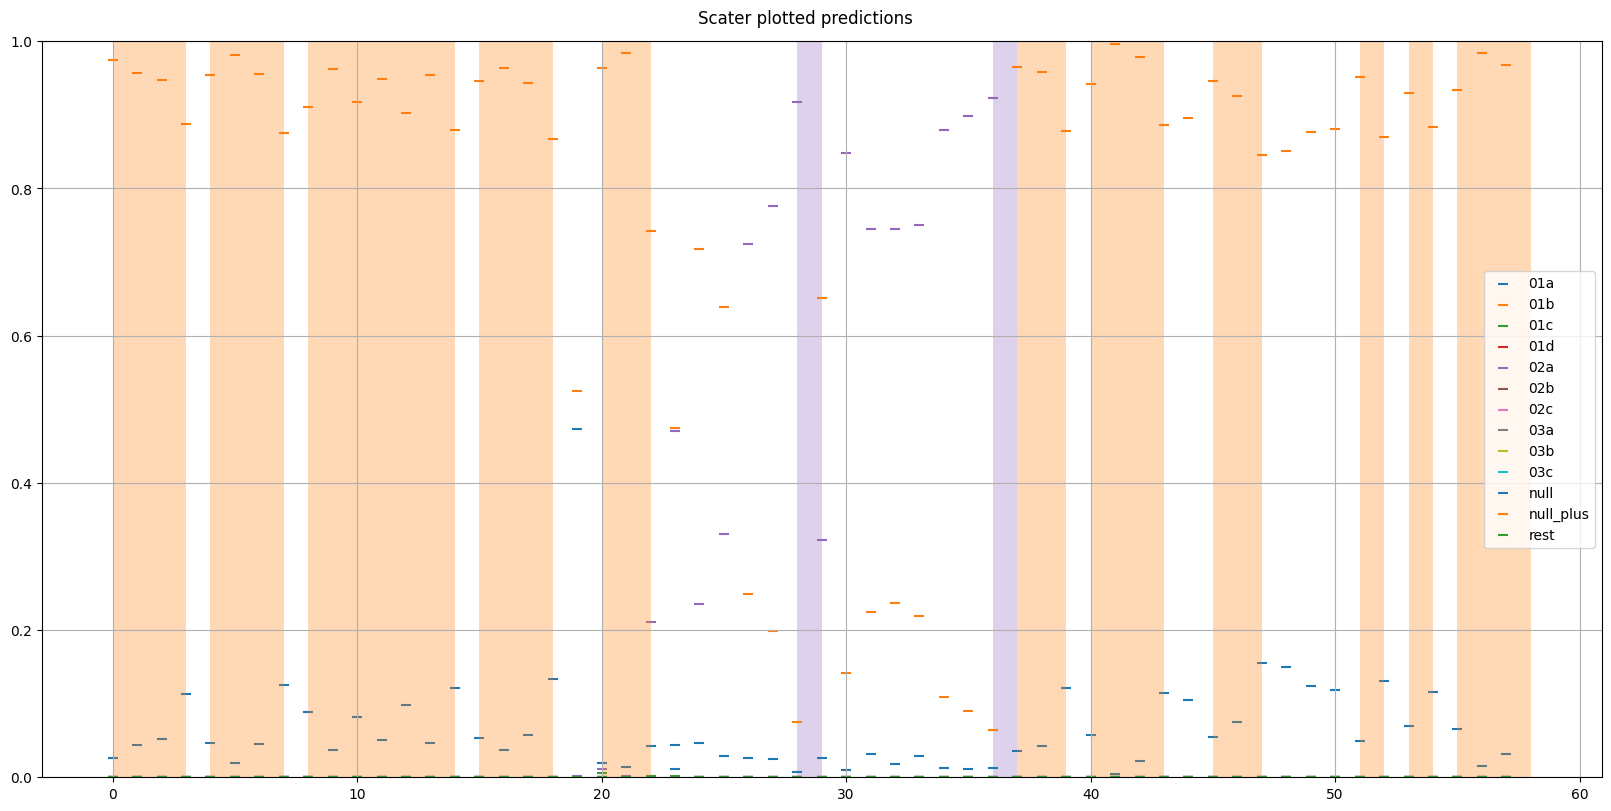

In [34]:
from crossai.visualization import plot_predictions

# plots the probability of each instance being
# a specific gesture with respect to time
plot_predictions(results["mean_pred"],
                 title="Scater plotted predictions", 
                 labels=list(le.classes_),
                 save_path=None, 
                 show=True,
                 s=50, 
                 color_threshold=0.9)

#### Batch pilot eval demo

In [39]:
from crossai.performance.batch_pilot_evaluation import batch_evaluate

# evaluate model on batch pilot data and save results
batch_evaluate(
    modality='tabular',
    model=cnn1d,
    folder=config["PATH"]["EVALUATION"]["DIR"],
    classes=list(le.classes_),
    pipeline=pipe,
    save_path=config["PATH"]["SAVE"]["BATCH_EVALUATION"],
    per_window=False,
    repeats=2)

Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.03 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.02 seconds to transform.
4/4 [==============================] - 0s 31ms/step
Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.01 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.01 seconds to transform.
3/3 [==============================] - 0s 44ms/step
Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.01 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.01 seconds to transform.
2/2 [==============================] - 0s 72ms/step
